In [1]:
import os
import glob
import math
import time
import argparse
import logging
import random
from dataclasses import dataclass, field
from typing import List, Optional
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
from accelerate import Accelerator

import timm
from timm.models.vision_transformer import VisionTransformer

/Users/jayantdabas/Documents/GitHub/fl25-deep-learning-self-supervised/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
@dataclass
class SSLConfig:
    # --- Data & System ---
    data_path: str = "./data/unlabeled_images"
    image_size: int = 96
    
    # RTX 8000 (48GB) can handle massive batches with ViT-S/8. 
    # Larger batch = more negative samples (implicit) = better gradients.
    batch_size: int = 1024      
    num_workers: int = 12       # High throughput needed for small images
    
    # --- Model (ViT-Small/8) ---
    arch: str = "vit_small"
    patch_size: int = 8         # CRITICAL: 8x8 patches for 96px input (144 tokens)
    embed_dim: int = 384
    
    # Reduced from 65536. 
    # For 500k images, 65k prototypes is overkill and hard to learn. 
    # 16k is denser and stabilizes convergence on smaller datasets.
    out_dim: int = 16384        
    norm_last_layer: bool = True
    
    # --- Optimization (The "Recipe") ---
    epochs: int = 100           # 100 is enough for 500k images with Multi-Crop
    
    # Learning Rate:
    # Rule of thumb: 0.0005 * (BatchSize / 256). 
    # For BS=1024, this is 0.002.
    lr: float = 0.002           
    min_lr: float = 1e-6
    
    # Weight Decay:
    # We start lower (0.04) to let features grow, then tighten (0.4) 
    # to compact the hypersphere.
    weight_decay: float = 0.04
    weight_decay_end: float = 0.4
    
    warmup_epochs: int = 10
    clip_grad: float = 3.0
    
    # --- Teacher Momentum (Stability) ---
    # Start higher (0.996) because small batches/images are noisier.
    # We want the teacher to be a "stable anchor".
    momentum_teacher: float = 0.996 
    
    # --- Extreme Multi-Crop (The Accuracy Booster) ---
    # seeing 2 global + 8 local = 10 views per image per step.
    # 1024 batch * 10 views = 10,240 effective examples per step.
    local_crops_number: int = 8
    
    # Crops for 96px:
    # Global: 40% to 100% of image
    # Local:  20% to 40% of image (small object parts)
    global_crops_scale: tuple = (0.4, 1.0)
    local_crops_scale: tuple = (0.2, 0.4)
    local_crops_size: int = 48
    
    # --- Checkpointing ---
    output_dir: str = "./checkpoints_ssl"
    keep_last_k: int = 10
    save_freq: int = 1

In [191]:
class DataAugmentationDINO:
    def __init__(self, global_crops_scale, local_crops_scale, local_crops_number, local_crops_size):
        # 1. Standard Color Jitter (Keep this)
        flip_and_color_jitter = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply(
                [transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)],
                p=0.8
            ),
            transforms.RandomGrayscale(p=0.2),
        ])
        
        # 2. Normalize (Standard ImageNet)
        normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])

        # ================= GLOBAL CROPS (TEACHER) =================
        # Changes: Kernel size 5 -> 3.
        self.global_transfo1 = transforms.Compose([
            transforms.RandomResizedCrop(96, scale=global_crops_scale, interpolation=Image.BICUBIC),
            flip_and_color_jitter,
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)), # Reduced kernel
            normalize,
        ])
        
        self.global_transfo2 = transforms.Compose([
            transforms.RandomResizedCrop(96, scale=global_crops_scale, interpolation=Image.BICUBIC),
            flip_and_color_jitter,
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)), # Reduced kernel
            transforms.RandomSolarize(threshold=128, p=0.2),
            normalize,
        ])
        
        # ================= LOCAL CROPS (STUDENT) =================
        # Changes: REMOVED Gaussian Blur completely.
        # Added RandomSolarize with low prob to force shape learning over texture.
        self.local_transfo = transforms.Compose([
            transforms.RandomResizedCrop(local_crops_size, scale=local_crops_scale, interpolation=Image.BICUBIC),
            flip_and_color_jitter,
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
            transforms.RandomSolarize(threshold=128, p=0.1), # Gentle solarization
            normalize,
        ])

        self.local_crops_number = local_crops_number

    def __call__(self, image):
        crops = []
        crops.append(self.global_transfo1(image))
        crops.append(self.global_transfo2(image))
        for _ in range(self.local_crops_number):
            crops.append(self.local_transfo(image))
        return crops

In [192]:
cfg = SSLConfig(
    data_path='../dataset/images',
    batch_size=32,
    num_workers=0
)

In [193]:
transform = DataAugmentationDINO(
    cfg.global_crops_scale,
    cfg.local_crops_scale,
    cfg.local_crops_number,
    cfg.local_crops_size
)
dataset = ImageFolderDataset(cfg.data_path, transform=transform)

In [194]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def normalize_image(data):
    """
    Scales image data from any float range to [0.0, 1.0].
    """
    data = data.numpy().copy() # Work on a copy
    data_min = np.min(data)
    data_max = np.max(data)
    # Avoid division by zero if all pixels are the same value
    if data_max - data_min == 0:
        return np.zeros_like(data)
        
    # Standard Min-Max normalization formula: (X - min) / (max - min)
    normalized_data = (data - data_min) / (data_max - data_min)
    return normalized_data

def display_images_grid(images_list, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3)) # Adjust figsize as needed
    axes = axes.flatten() # Flatten the 2D array of axes to easily iterate

    for i, im in enumerate(images_list[:rows*cols]):
        corrected_image_data = np.transpose(im, (1, 2, 0))
        corrected_image_data = normalize_image(corrected_image_data)
        axes[i].imshow(corrected_image_data)
        axes[i].axis('off') # Hide the axis ticks and labels

    plt.tight_layout()
    plt.show()


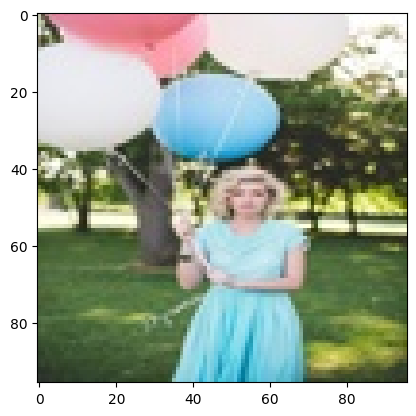

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

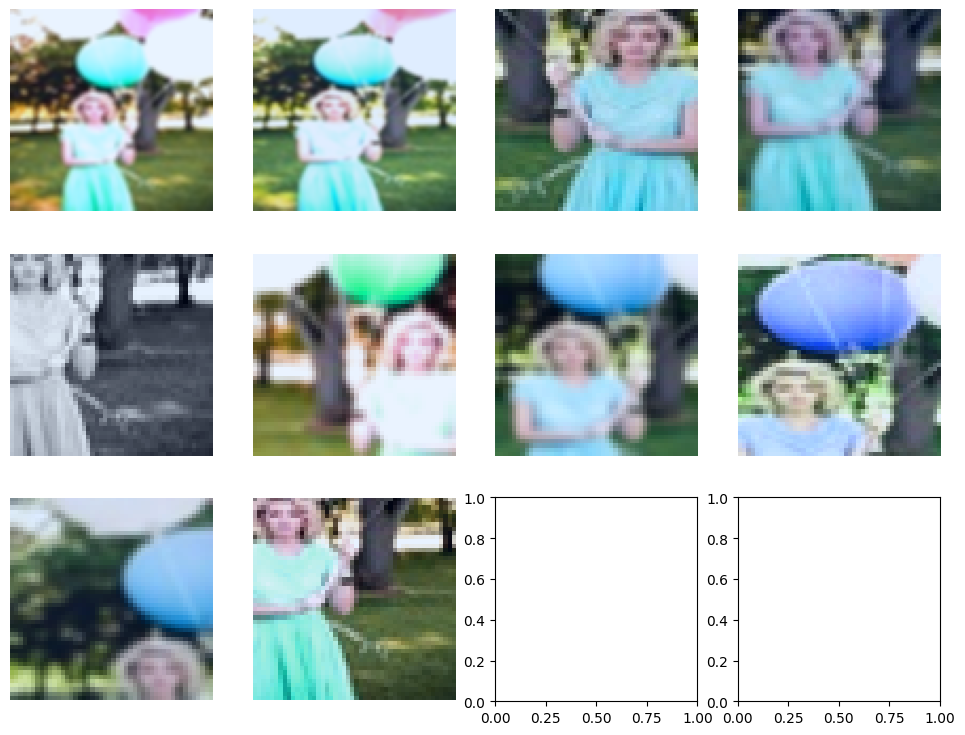

In [197]:
img = dataset[1000]
plt.imshow(img[-1])
plt.show()
display_images_grid(img, rows=3, cols=4)